## 1. Wczytanie bibliotek

In [1]:
import pandas as pd
import json
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import matplotlib.pyplot as plt

## 2. Definicje funkcji używanych w programie

In [2]:
def renameColumns(df, feature):
    df.columns = ['stationCode', 'measureCode', 'dateTime', feature, 'empty']
    return df.drop(columns=['empty'])

In [3]:
def removeNotWarsaw(df):
    return df[df.stationCode
            .apply(lambda stationCode: stationCode == 352200375)]

In [4]:
def splitDate(df):
    df['month'] = df.apply(
        lambda row: row.dateTime.split('-')[1], axis = 1)
    df['day'] = df.apply(
        lambda row: row.dateTime.split('-')[2][0:2], axis = 1)
    df['hour'] = df.apply(
        lambda row: row.dateTime.split('-')[2][3:5], axis = 1)
    df['minute'] = df.apply(
        lambda row: row.dateTime.split('-')[2][6:8], axis = 1)

In [5]:
def addWeekDay(df):
    df['weekDay'] = df.apply(
        lambda row: 1 + ((int(row['day']) + 2) % 7),
    axis = 1)

In [6]:
def whichDayPart(hour):
    if hour > 2 and hour <= 4:
        return 1
    elif hour > 4 and hour <= 6:
        return 2
    elif hour > 6 and hour <= 8:
        return 3
    elif hour > 8 and hour <= 10:
        return 4
    elif hour > 10 and hour <= 12:
        return 5
    elif hour > 12 and hour <= 14:
        return 6
    elif hour > 14 and hour <= 16:
        return 7  
    elif hour > 16 and hour <= 18:
        return 8
    elif hour > 18 and hour <= 20:
        return 9
    elif hour > 20 and hour <= 22:
        return 10 
    else:
        return 0

In [7]:
def prepareWeatherDF(file, name):
    dfToCut = pd.read_csv(file, header = None, delimiter = ';')
    df = renameColumns(dfToCut, name)
    df = removeNotWarsaw(df)
    splitDate(df)
    df = df.astype({'month': 'int64'})
    df = df.astype({'day': 'int64'})
    df = df.astype({'hour': 'int64'})
    df['dayPart'] = df.apply(
        lambda row: whichDayPart(row['hour']), axis = 1)
    df[name] = df[name].apply(
        lambda data: float(data.replace(',', '.')) if type(data) != float else data)
    return df

## 3. Wczytanie danych meteorologicznych

In [8]:
dfTemp = prepareWeatherDF('data\meteo\B00300S_2018_03.csv', 'temp')
dfWind = prepareWeatherDF('data\meteo\B00702A_2018_03.csv', 'wind')
dfRain = prepareWeatherDF('data\meteo\B00606S_2018_03.csv', 'rain')

## 4. Wczytanie danych rowerów miejskich

In [9]:
fileList = glob.glob("data\\rowery\\201803*.json")

In [10]:
df = pd.DataFrame(columns = ['date','year','month', 'day', 'hour', 'minute', 'rentBikes'])  
for fileName in fileList:
    if os.path.getsize(fileName) > 10000:
        with open(fileName, 'r') as json_file:
            data = json.load(json_file)
        df2 = pd.DataFrame([[
            fileName.split('\\')[2][0:13],
            fileName.split('\\')[2][0:4],
            fileName.split('\\')[2][4:6],
            fileName.split('\\')[2][6:8],
            fileName.split('\\')[2][9:11],
            fileName.split('\\')[2][11:13],
            int(data[0]['region_info']['set_point_bikes']) - int(data[0]['region_info']["available_bikes"])
        ]], columns = ['date','year','month', 'day', 'hour', 'minute', 'rentBikes'])
        df = df.append(df2) 

## 5. Przetworzenie danych meteorologicznych oraz danych z Warszawskich rowerów miejskich

In [11]:
addWeekDay(df)
df = df.astype({'date': 'int64'})
df = df.astype({'month': 'int64'})
df = df.astype({'day': 'int64'})
df = df.astype({'hour': 'int64'})
df = df.astype({'minute': 'int64'})
df = df.astype({'rentBikes': 'float'})
df['dayPart'] = df.apply(
    lambda row: whichDayPart(row['hour']), axis = 1)

In [12]:
df['prevRent'] = df.apply(
    lambda row: np.mean(df.loc[df['day'] == row['day'] - 7]['rentBikes']) if row['day'] > 10 else 0,
axis = 1)

In [13]:
df['temp'] = df.apply(
   lambda row: round(np.mean(dfTemp.loc[dfTemp['month'] == row['month']].loc[dfTemp['day'] == row['day']].loc[dfTemp['dayPart'] == row['dayPart']]['temp']), 2),
axis = 1)

In [14]:
df['rain'] = df.apply(
   lambda row: np.mean(dfRain.loc[dfRain['month'] == row['month']].loc[dfRain['day'] == row['day']].loc[dfRain['dayPart'] == row['dayPart']]['rain']),
axis = 1)

In [15]:
df['wind'] = df.apply(
   lambda row: round(np.mean(dfWind.loc[dfWind['month'] == row['month']].loc[dfWind['day'] == row['day']].loc[dfWind['dayPart'] == row['dayPart']]['wind']), 2),
axis = 1)

## 6. Wykresy punktowe pokazujące zależności danych meteorologicznych od wynajętych rowerów

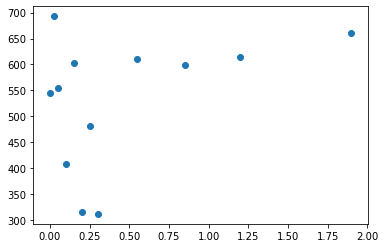

In [16]:
weekDayMean = df.groupby('rain').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

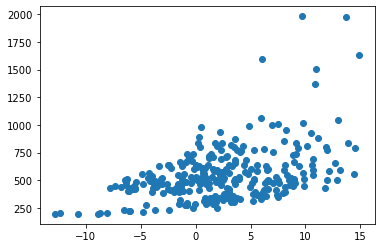

In [17]:
weekDayMean = df.groupby('temp').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

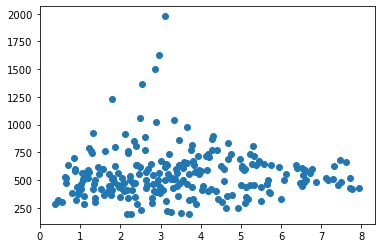

In [18]:
weekDayMean = df.groupby('wind').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

## 7. Usunięcie brakujących wartości oraz odstających wartości, zauważonych podczas analizy wykresu wynajęcia rowerów od deszczu

In [19]:
df = df.dropna()

In [20]:
df = df[np.abs(df.rain-df.rain.mean()) <= (3*df.rain.std())]

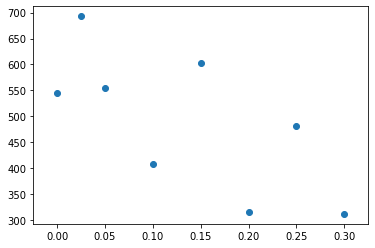

In [21]:
weekDayMean = df.groupby('rain').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

## 8. Tworzenie modelu oraz podział zbioru na treningowy, walidacyjny i testowy

In [22]:
x = df[['weekDay', 'dayPart', 'temp', 'rain', 'wind', 'hour', 'prevRent', 'date', 'day']]
y = df['rentBikes']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

In [23]:
x_train_df = x_train.copy()
x_test_df = x_test.copy()
x_valid_df = x_valid.copy()
del x_train['date']
del x_test['date']
del x_valid['date']
del x_train['day']
del x_test['day']
del x_valid['day']

In [24]:
poly = PolynomialFeatures(4)
X_train = poly.fit_transform(x_train)
X_test = poly.fit_transform(x_test)
X_valid = poly.fit_transform(x_valid)
X = poly.fit_transform(x)

## 9. Predykcja

In [25]:
regr = linear_model.LinearRegression(normalize = True)
regr.fit(X_train,y_train)
y_pred_train = regr.predict(X_train)
y_pred_valid = regr.predict(X_valid)

In [26]:
print(sklearn.metrics.mean_absolute_error(y_train, y_pred_train))
print(sklearn.metrics.r2_score(y_train, y_pred_train))
print(sklearn.metrics.mean_absolute_error(y_valid, y_pred_valid))
print(sklearn.metrics.r2_score(y_valid, y_pred_valid))

40.22941666612739
0.9321134954866758
45.565794268994374
0.9251597278964622


In [27]:
y_pred_test = regr.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_test, y_pred_test))
print(sklearn.metrics.r2_score(y_test, y_pred_test))

44.79482915900731
0.9226386672393241


## 10. Wykresy zależności wynajętych rowerów od przewidywania wynajęcia rowerów od daty

In [28]:
x_train_df = x_train_df.astype({'date': 'str'})
df_date = pd.DataFrame({'year': x_train_df['date'].str[0:4],
                 'month': x_train_df['date'].str[4:6],
                 'day': x_train_df['date'].str[6:8],
                 'hour': x_train_df['date'].str[8:10],
                 'minute':x_train_df['date'].str[10:12]})

In [29]:
x_valid_df = x_valid_df.astype({'date': 'str'})
df_date_valid = pd.DataFrame({'year': x_valid_df['date'].str[0:4],
                 'month': x_valid_df['date'].str[4:6],
                 'day': x_valid_df['date'].str[6:8],
                 'hour': x_valid_df['date'].str[8:10],
                 'minute':x_valid_df['date'].str[10:12]})

In [30]:
x_test_df = x_test_df.astype({'date': 'str'})
df_date_test = pd.DataFrame({'year': x_test_df['date'].str[0:4],
                 'month': x_test_df['date'].str[4:6],
                 'day': x_test_df['date'].str[6:8],
                 'hour': x_test_df['date'].str[8:10],
                 'minute':x_test_df['date'].str[10:12]})

In [31]:
x_train_df['date'] = pd.to_datetime(df_date)
x_valid_df['date'] = pd.to_datetime(df_date_valid) 
x_test_df['date'] = pd.to_datetime(df_date_test) 

In [32]:
x_train_df = pd.concat([x_train_df, y_train], axis=1)
x_valid_df = pd.concat([x_valid_df, y_valid], axis=1)
x_test_df = pd.concat([x_test_df, y_test], axis=1)

In [34]:
x_train_df.index=range(0,2364)
x_valid_df.index=range(0,789)
x_test_df.index=range(0,789)

In [35]:
pred_train = {'rentBikesPred':y_pred_train}
y_pred_train_df = pd.DataFrame(pred_train)
y_pred_train_df = round(y_pred_train_df,2)

In [36]:
pred_valid = {'rentBikesPred':y_pred_valid}
y_pred_valid_df = pd.DataFrame(pred_valid)
y_pred_valid_df = round(y_pred_valid_df,2)

In [37]:
pred_test = {'rentBikesPred':y_pred_test}
y_pred_test_df = pd.DataFrame(pred_test)
y_pred_test_df = round(y_pred_test_df,2)

In [38]:
x_train_df = pd.concat([x_train_df,y_pred_train_df], axis=1)
x_valid_df = pd.concat([x_valid_df,y_pred_valid_df], axis=1)
x_test_df = pd.concat([x_test_df,y_pred_test_df], axis=1)

In [39]:
del x_train_df['weekDay']
del x_train_df['temp']
del x_train_df['rain']
del x_train_df['wind']
del x_train_df['prevRent']
del x_valid_df['weekDay']
del x_valid_df['temp']
del x_valid_df['rain']
del x_valid_df['wind']
del x_valid_df['prevRent']
del x_test_df['weekDay']
del x_test_df['temp']
del x_test_df['rain']
del x_test_df['wind']
del x_test_df['prevRent']

In [40]:
x_train_df = x_train_df.sort_values(['day','hour'])
x_valid_df = x_valid_df.sort_values(['day','hour'])
x_test_df = x_test_df.sort_values(['day','hour'])

c:\users\maja\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'rentBikes')

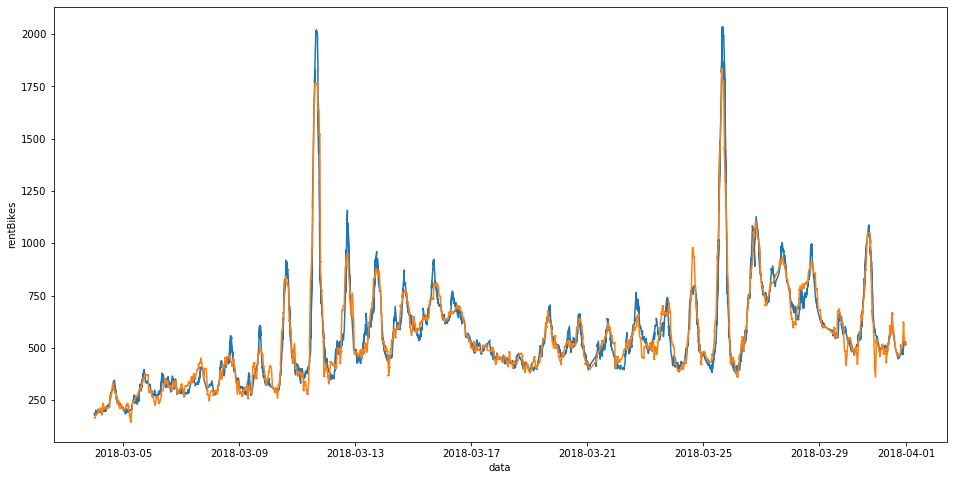

In [41]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x_train_df['date'], x_train_df['rentBikes'], x_train_df['date'], x_train_df['rentBikesPred'])
ax.set_xlabel('data')
ax.set_ylabel('rentBikes')

Text(0, 0.5, 'rentBikes')

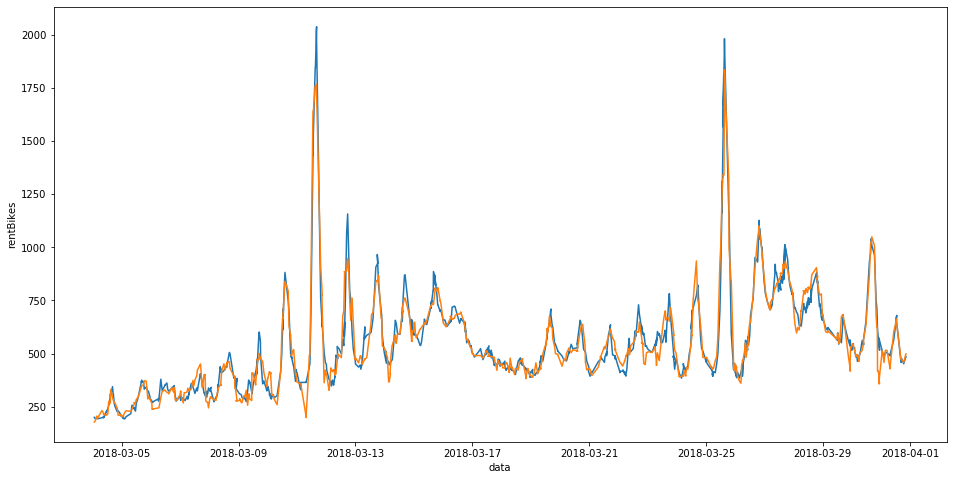

In [42]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x_valid_df['date'], x_valid_df['rentBikes'], x_valid_df['date'], x_valid_df['rentBikesPred'])
ax.set_xlabel('data')
ax.set_ylabel('rentBikes')

Text(0, 0.5, 'rentBikes')

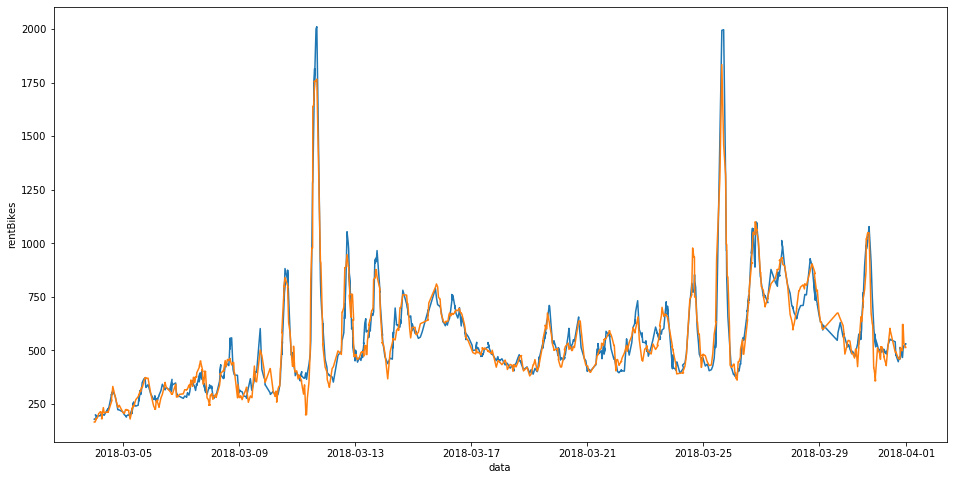

In [43]:
fig, ax2 = plt.subplots(figsize=(16,8))
ax2.plot(x_test_df['date'], x_test_df['rentBikes'], x_test_df['date'], x_test_df['rentBikesPred'])
ax2.set_xlabel('data')
ax2.set_ylabel('rentBikes')